# Lab 5


## JMuBEN2 dataset


(https://data.mendeley.com/datasets/tgv3zb82nd/1)

Image dataset taken from an Arabica coffee plantation. The image dataset contains collection of healthy and miner coffee leaves.

We used the same dataset that we used in Lab 4.

# Loading and Spliting the dataset 

In [1]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [2]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [3]:
# print the number of images and labels

print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")


Train images:24000  Labels:24000
Test images:6000  Labels:6000


# Pre-processing and Normalization

Images in the dataset were converted to grayscale and resized to 128x128

Tried loading as described https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [4]:
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def load_grayscale_images(image_paths):
    loaded_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        loaded_images.append(img)
    return loaded_images

def resize_images(images_to_resize):
    resized_images = []
    for img in images_to_resize:
        resized_img = cv2.resize(img, (128, 128))  # resize
        resized_images.append(resized_img)
    return resized_images

def normalize_image(images_to_normalize):
    normalized_images = []
    for img in images_to_normalize:
        normalized_img = img / 255.0  # normalize
        normalized_images.append(normalized_img)
    return normalized_images

image_pipeline = Pipeline(steps=[
    ('load_grayscale_images', FunctionTransformer(load_grayscale_images)),
    ('resize_images', FunctionTransformer(resize_images)),
    ('normalize_image', FunctionTransformer(normalize_image))
])


train_images=image_pipeline.transform(train_images_dir)
test_images=image_pipeline.transform(test_images_dir)

In [5]:
print(len(train_images))
print(len(test_images))

24000
6000


# Model Training

In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

train_images = train_images.reshape(train_images.shape[0], -1)
train_labels = train_labels.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

### 1) Multinomial Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha=1.0e-10, force_alpha=True , class_prior=[0.4, 0.6])
train_labels = train_labels.ravel()
clf1.fit(train_images, train_labels)
predictions1 = clf1.predict(test_images)

##### Model Evaluation


In [8]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy = accuracy_score(test_labels, predictions1)
print('Accuracy = ', accuracy)

Accuracy =  0.6163333333333333


In [9]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions1)
confusion_matrix

array([[1289, 1711],
       [ 591, 2409]])

In [10]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1289
FP =  591
TN =  2409
FN =  1711


In [11]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.42966666666666664
Specificity =  0.803


In [12]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_labels, predictions1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions1)
print('Recall = ', recall)

Precision =  0.5847087378640776
Recall =  0.803


Area Under Curve =  0.5560877777777777


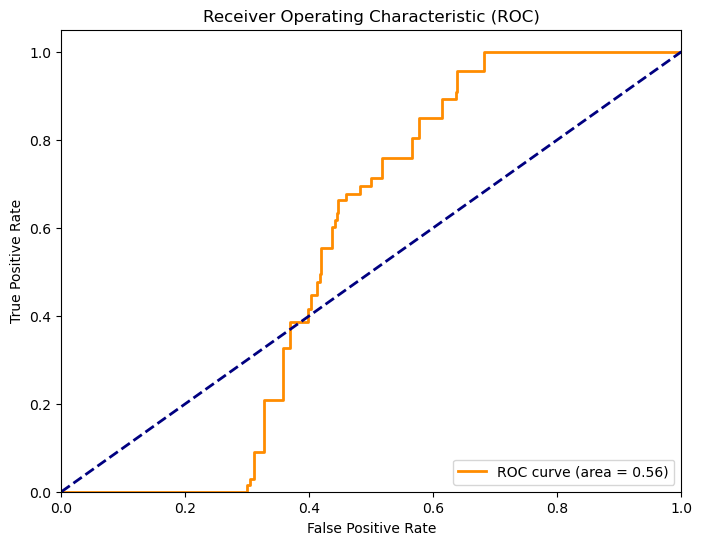

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the positive class
probabilities = clf1.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 2) Gaussian Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
clf2.fit(train_images, train_labels)
predictions2 = clf2.predict(test_images)

##### Model Evaluation


In [15]:
# accuracy
accuracy = accuracy_score(test_labels, predictions2)
print('Accuracy = ', accuracy)

Accuracy =  0.6563333333333333


In [16]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions2)
confusion_matrix

array([[2336,  664],
       [1398, 1602]])

In [17]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  2336
FP =  1398
TN =  1602
FN =  664


In [18]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.7786666666666666
Specificity =  0.534


In [19]:
precision = precision_score(test_labels, predictions2)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions2)
print('Recall = ', recall)

Precision =  0.706972639011474
Recall =  0.534


Area Under Curve =  0.6530066666666666


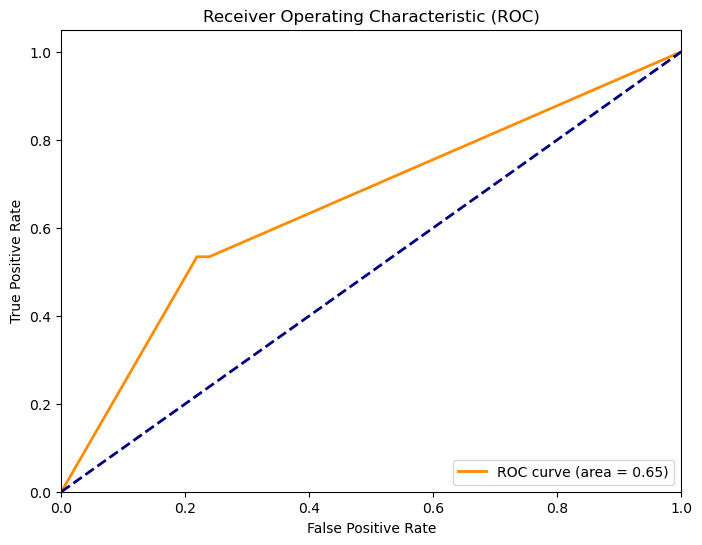

In [20]:
# Calculate predicted probabilities for the positive class
probabilities = clf2.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 3) Complement Naive Bayes

In [21]:
from sklearn.naive_bayes import ComplementNB
clf3 = ComplementNB(force_alpha=True)
clf3.fit(train_images, train_labels)
predictions3 = clf3.predict(test_images)

##### Model Evaluation


In [22]:
# accuracy
accuracy = accuracy_score(test_labels, predictions3)
print('Accuracy = ', accuracy)

Accuracy =  0.599


In [23]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions3)
confusion_matrix

array([[1319, 1681],
       [ 725, 2275]])

In [24]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1319
FP =  725
TN =  2275
FN =  1681


In [25]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.43966666666666665
Specificity =  0.7583333333333333


In [26]:
precision = precision_score(test_labels, predictions3)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions3)
print('Recall = ', recall)

Precision =  0.5750758341759353
Recall =  0.7583333333333333


Area Under Curve =  0.5560877777777778


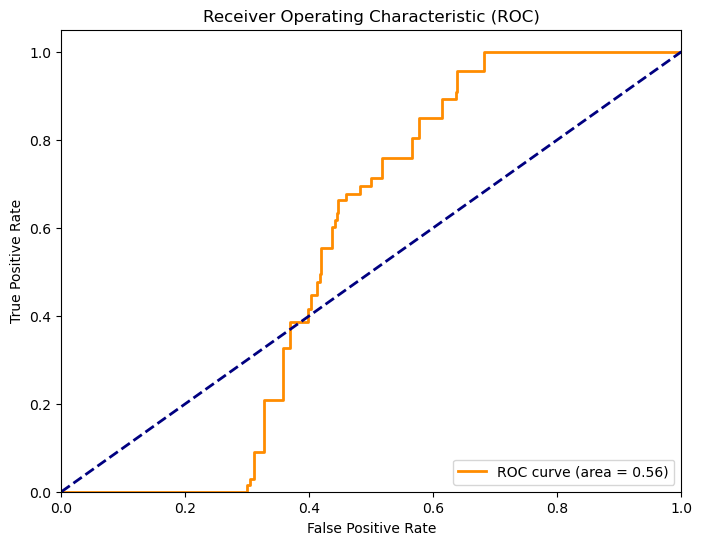

In [27]:
# Calculate predicted probabilities for the positive class
probabilities = clf3.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 4) Bernoulli Naive Bayes

In [28]:
from sklearn.naive_bayes import BernoulliNB
clf4 = BernoulliNB(force_alpha=True)
clf4.fit(train_images, train_labels)
predictions4 = clf4.predict(test_images)

##### Model Evaluation


In [29]:
# accuracy
accuracy = accuracy_score(test_labels, predictions4)
print('Accuracy = ', accuracy)

Accuracy =  0.5


In [30]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions4)
confusion_matrix

array([[3000,    0],
       [3000,    0]])

In [31]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  3000
FP =  3000
TN =  0
FN =  0


In [32]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  1.0
Specificity =  0.0


In [33]:
precision = precision_score(test_labels, predictions4, zero_division=1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions4, zero_division=1)
print('Recall = ', recall)

Precision =  1.0
Recall =  0.0


Area Under Curve =  0.5


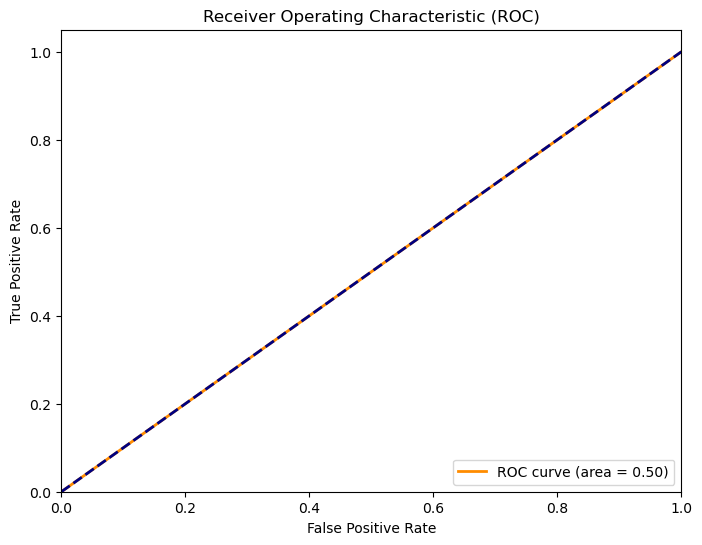

In [34]:
# Calculate predicted probabilities for the positive class
probabilities = clf4.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 5) Categorical Naive Bayes

In [35]:
from sklearn.naive_bayes import CategoricalNB
clf5 = CategoricalNB(force_alpha=True)
clf5.fit(train_images, train_labels)
predictions5 = clf5.predict(test_images)

##### Model Evaluation


In [36]:
# accuracy
accuracy = accuracy_score(test_labels, predictions5)
print('Accuracy = ', accuracy)

Accuracy =  0.6608333333333334


In [37]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions5)
confusion_matrix

array([[ 965, 2035],
       [   0, 3000]])

In [38]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  965
FP =  0
TN =  3000
FN =  2035


In [39]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.32166666666666666
Specificity =  1.0


In [40]:
precision = precision_score(test_labels, predictions5)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions5)
print('Recall = ', recall)

Precision =  0.5958291956305859
Recall =  1.0


Area Under Curve =  0.7348333333333333


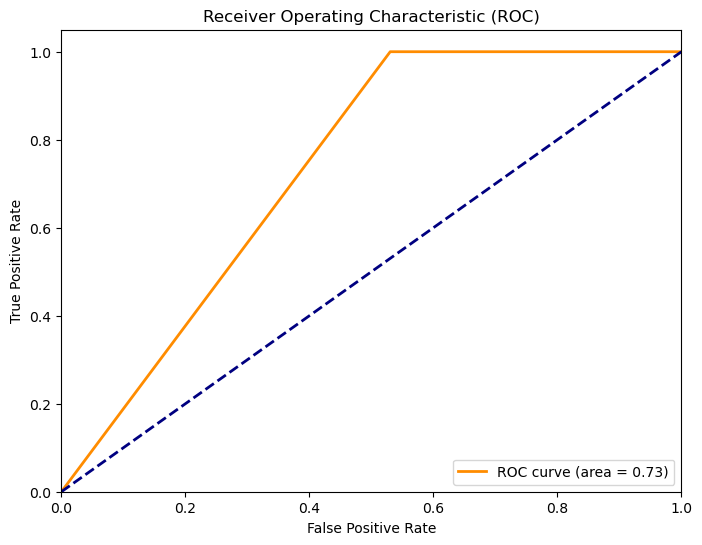

In [41]:
# Calculate predicted probabilities for the positive class
probabilities = clf5.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()